In [ ]:
!pip install torch torchvision opencv-python-headless tqdm huggingface_hub

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose
from tqdm import tqdm
from huggingface_hub import PyTorchModelHubMixin

In [ ]:
# Helper functions and classes
def _make_scratch(in_shape, out_shape, groups=1, expand=False):
    scratch = nn.Module()
    out_shape1 = out_shape
    out_shape2 = out_shape
    out_shape3 = out_shape
    if len(in_shape) >= 4:
        out_shape4 = out_shape

    if expand:
        out_shape1 = out_shape
        out_shape2 = out_shape * 2
        out_shape3 = out_shape * 4
        if len(in_shape) >= 4:
            out_shape4 = out_shape * 8

    scratch.layer1_rn = nn.Conv2d(
        in_shape[0], out_shape1, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
    )
    scratch.layer2_rn = nn.Conv2d(
        in_shape[1], out_shape2, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
    )
    scratch.layer3_rn = nn.Conv2d(
        in_shape[2], out_shape3, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
    )
    if len(in_shape) >= 4:
        scratch.layer4_rn = nn.Conv2d(
            in_shape[3], out_shape4, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
        )

    return scratch


class ResidualConvUnit(nn.Module):
    def __init__(self, features, activation, bn):
        super().__init__()
        self.bn = bn
        self.groups = 1
        self.conv1 = nn.Conv2d(
            features, features, kernel_size=3, stride=1, padding=1, bias=True, groups=self.groups
        )
        self.conv2 = nn.Conv2d(
            features, features, kernel_size=3, stride=1, padding=1, bias=True, groups=self.groups
        )
        if self.bn:
            self.bn1 = nn.BatchNorm2d(features)
            self.bn2 = nn.BatchNorm2d(features)
        self.activation = activation
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x):
        out = self.activation(x)
        out = self.conv1(out)
        if self.bn:
            out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        if self.bn:
            out = self.bn2(out)
        return self.skip_add.add(out, x)


class FeatureFusionBlock(nn.Module):
    def __init__(self, features, activation, deconv=False, bn=False, expand=False, align_corners=True, size=None):
        super().__init__()
        self.deconv = deconv
        self.align_corners = align_corners
        self.groups = 1
        self.expand = expand
        out_features = features
        if self.expand:
            out_features = features // 2
        self.out_conv = nn.Conv2d(features, out_features, kernel_size=1, stride=1, padding=0, bias=True, groups=1)
        self.resConfUnit1 = ResidualConvUnit(features, activation, bn)
        self.resConfUnit2 = ResidualConvUnit(features, activation, bn)
        self.skip_add = nn.quantized.FloatFunctional()
        self.size = size

    def forward(self, *xs, size=None):
        output = xs[0]
        if len(xs) == 2:
            res = self.resConfUnit1(xs[1])
            output = self.skip_add.add(output, res)
        output = self.resConfUnit2(output)
        if size is None and self.size is None:
            modifier = {"scale_factor": 2}
        elif size is None:
            modifier = {"size": self.size}
        else:
            modifier = {"size": size}
        output = F.interpolate(output, **modifier, mode="bilinear", align_corners=self.align_corners)
        output = self.out_conv(output)
        return output


def _make_fusion_block(features, use_bn, size=None):
    return FeatureFusionBlock(
        features,
        nn.ReLU(False),
        deconv=False,
        bn=use_bn,
        expand=False,
        align_corners=True,
        size=size,
    )


class DPTHead(nn.Module):
    def __init__(self, nclass, in_channels, features=256, use_bn=False, out_channels=[256, 512, 1024, 1024], use_clstoken=False):
        super().__init__()
        self.nclass = nclass
        self.use_clstoken = use_clstoken
        self.projects = nn.ModuleList([
            nn.Conv2d(in_channels, out_channel, kernel_size=1, stride=1, padding=0)
            for out_channel in out_channels
        ])
        self.resize_layers = nn.ModuleList([
            nn.ConvTranspose2d(out_channels[0], out_channels[0], kernel_size=4, stride=4, padding=0),
            nn.ConvTranspose2d(out_channels[1], out_channels[1], kernel_size=2, stride=2, padding=0),
            nn.Identity(),
            nn.Conv2d(out_channels[3], out_channels[3], kernel_size=3, stride=2, padding=1)
        ])
        if use_clstoken:
            self.readout_projects = nn.ModuleList()
            for _ in range(len(self.projects)):
                self.readout_projects.append(nn.Sequential(
                    nn.Linear(2 * in_channels, in_channels),
                    nn.GELU()
                ))
        self.scratch = _make_scratch(out_channels, features, groups=1, expand=False)
        self.scratch.stem_transpose = None
        self.scratch.refinenet1 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet2 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet3 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet4 = _make_fusion_block(features, use_bn)
        head_features_1 = features
        head_features_2 = 32
        if nclass > 1:
            self.scratch.output_conv = nn.Sequential(
                nn.Conv2d(head_features_1, head_features_1, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.Conv2d(head_features_1, nclass, kernel_size=1, stride=1, padding=0),
            )
        else:
            self.scratch.output_conv1 = nn.Conv2d(head_features_1, head_features_1 // 2, kernel_size=3, stride=1, padding=1)
            self.scratch.output_conv2 = nn.Sequential(
                nn.Conv2d(head_features_1 // 2, head_features_2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.Conv2d(head_features_2, 1, kernel_size=1, stride=1, padding=0),
                nn.ReLU(True),
                nn.Identity(),
            )

    def forward(self, out_features, patch_h, patch_w):
        out = []
        for i, x in enumerate(out_features):
            if self.use_clstoken:
                x, cls_token = x[0], x[1]
                readout = cls_token.unsqueeze(1).expand_as(x)
                x = self.readout_projects[i](torch.cat((x, readout), -1))
            else:
                x = x[0]
            x = x.permute(0, 2, 1).reshape((x.shape[0], x.shape[-1], patch_h, patch_w))
            x = self.projects[i](x)
            x = self.resize_layers[i](x)
            out.append(x)
        layer_1, layer_2, layer_3, layer_4 = out
        layer_1_rn = self.scratch.layer1_rn(layer_1)
        layer_2_rn = self.scratch.layer2_rn(layer_2)
        layer_3_rn = self.scratch.layer3_rn(layer_3)
        layer_4_rn = self.scratch.layer4_rn(layer_4)
        path_4 = self.scratch.refinenet4(layer_4_rn, size=layer_3_rn.shape[2:])
        path_3 = self.scratch.refinenet3(path_4, layer_3_rn, size=layer_2_rn.shape[2:])
        path_2 = self.scratch.refinenet2(path_3, layer_2_rn, size=layer_1_rn.shape[2:])
        path_1 = self.scratch.refinenet1(path_2, layer_1_rn)
        out = self.scratch.output_conv1(path_1)
        out = F.interpolate(out, (int(patch_h * 14), int(patch_w * 14)), mode="bilinear", align_corners=True)
        out = self.scratch.output_conv2(out)
        return out


class DPT_DINOv2(nn.Module):
    def __init__(self, encoder='vitl', features=256, out_channels=[256, 512, 1024, 1024], use_bn=False, use_clstoken=False, localhub=False):  # Set localhub=False
        super().__init__()
        assert encoder in ['vits', 'vitb', 'vitl']
        if localhub:
            self.pretrained = torch.hub.load('torchhub/facebookresearch_dinov2_main', f'dinov2_{encoder}14', source='local', pretrained=False)
        else:
            self.pretrained = torch.hub.load('facebookresearch/dinov2', f'dinov2_{encoder}14')  # Download from internet
        dim = self.pretrained.blocks[0].attn.qkv.in_features
        self.depth_head = DPTHead(1, dim, features, use_bn, out_channels=out_channels, use_clstoken=use_clstoken)

    def forward(self, x):
        h, w = x.shape[-2:]
        features = self.pretrained.get_intermediate_layers(x, 4, return_class_token=True)
        patch_h, patch_w = h // 14, w // 14
        depth = self.depth_head(features, patch_h, patch_w)
        depth = F.interpolate(depth, size=(h, w), mode="bilinear", align_corners=True)
        depth = F.relu(depth)
        return depth.squeeze(1)


class DepthAnything(DPT_DINOv2, PyTorchModelHubMixin):
    def __init__(self, config):
        super().__init__(**config)

In [ ]:
class Resize:
    def __init__(self, width, height, resize_target=True, keep_aspect_ratio=False, ensure_multiple_of=1, resize_method="lower_bound", image_interpolation_method=cv2.INTER_AREA):
        self.__width = width
        self.__height = height
        self.__resize_target = resize_target
        self.__keep_aspect_ratio = keep_aspect_ratio
        self.__multiple_of = ensure_multiple_of
        self.__resize_method = resize_method
        self.__image_interpolation_method = image_interpolation_method

    def constrain_to_multiple_of(self, x, min_val=0, max_val=None):
        y = (np.round(x / self.__multiple_of) * self.__multiple_of).astype(int)
        if max_val is not None and y > max_val:
            y = (np.floor(x / self.__multiple_of) * self.__multiple_of).astype(int)
        if y < min_val:
            y = (np.ceil(x / self.__multiple_of) * self.__multiple_of).astype(int)
        return y

    def get_size(self, width, height):
        scale_height = self.__height / height
        scale_width = self.__width / width
        if self.__keep_aspect_ratio:
            if self.__resize_method == "lower_bound":
                if scale_width > scale_height:
                    scale_height = scale_width
                else:
                    scale_width = scale_height
            elif self.__resize_method == "upper_bound":
                if scale_width < scale_height:
                    scale_height = scale_width
                else:
                    scale_width = scale_height
            elif self.__resize_method == "minimal":
                if abs(1 - scale_width) < abs(1 - scale_height):
                    scale_height = scale_width
                else:
                    scale_width = scale_height
            else:
                raise ValueError(f"resize_method {self.__resize_method} not implemented")

        if self.__resize_method == "lower_bound":
            new_height = self.constrain_to_multiple_of(scale_height * height, min_val=self.__height)
            new_width = self.constrain_to_multiple_of(scale_width * width, min_val=self.__width)
        elif self.__resize_method == "upper_bound":
            new_height = self.constrain_to_multiple_of(scale_height * height, max_val=self.__height)
            new_width = self.constrain_to_multiple_of(scale_width * width, max_val=self.__width)
        elif self.__resize_method == "minimal":
            new_height = self.constrain_to_multiple_of(scale_height * height)
            new_width = self.constrain_to_multiple_of(scale_width * width)
        else:
            raise ValueError(f"resize_method {self.__resize_method} not implemented")

        return (new_width, new_height)

    def __call__(self, sample):
        width, height = self.get_size(sample["image"].shape[1], sample["image"].shape[0])
        sample["image"] = cv2.resize(sample["image"], (width, height), interpolation=self.__image_interpolation_method)
        if self.__resize_target:
            if "disparity" in sample:
                sample["disparity"] = cv2.resize(sample["disparity"], (width, height), interpolation=cv2.INTER_NEAREST)
            if "depth" in sample:
                sample["depth"] = cv2.resize(sample["depth"], (width, height), interpolation=cv2.INTER_NEAREST)
            if "mask" in sample:
                sample["mask"] = cv2.resize(sample["mask"].astype(np.float32), (width, height), interpolation=cv2.INTER_NEAREST)
        return sample


class NormalizeImage:
    def __init__(self, mean, std):
        self.__mean = mean
        self.__std = std

    def __call__(self, sample):
        sample["image"] = (sample["image"] - self.__mean) / self.__std
        return sample


class PrepareForNet:
    def __call__(self, sample):
        image = np.transpose(sample["image"], (2, 0, 1))
        sample["image"] = np.ascontiguousarray(image).astype(np.float32)
        if "mask" in sample:
            sample["mask"] = sample["mask"].astype(np.float32)
            sample["mask"] = np.ascontiguousarray(sample["mask"])
        if "depth" in sample:
            depth = sample["depth"].astype(np.float32)
            sample["depth"] = np.ascontiguousarray(depth)
        return sample

In [ ]:
# Define the transformations
transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

In [ ]:
# Load the model
encoder = 'vits'  # You can change this to 'vitb' or 'vitl' if needed
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
depth_anything = DepthAnything.from_pretrained(f'LiheYoung/depth_anything_{encoder}14').to(DEVICE)
depth_anything.eval()

# Print total parameters
total_params = sum(param.numel() for param in depth_anything.parameters())
print(f'Total parameters: {total_params / 1e6:.2f}M')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 108MB/s]


pytorch_model.bin:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

Total parameters: 24.79M


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


<IPython.core.display.Javascript object>

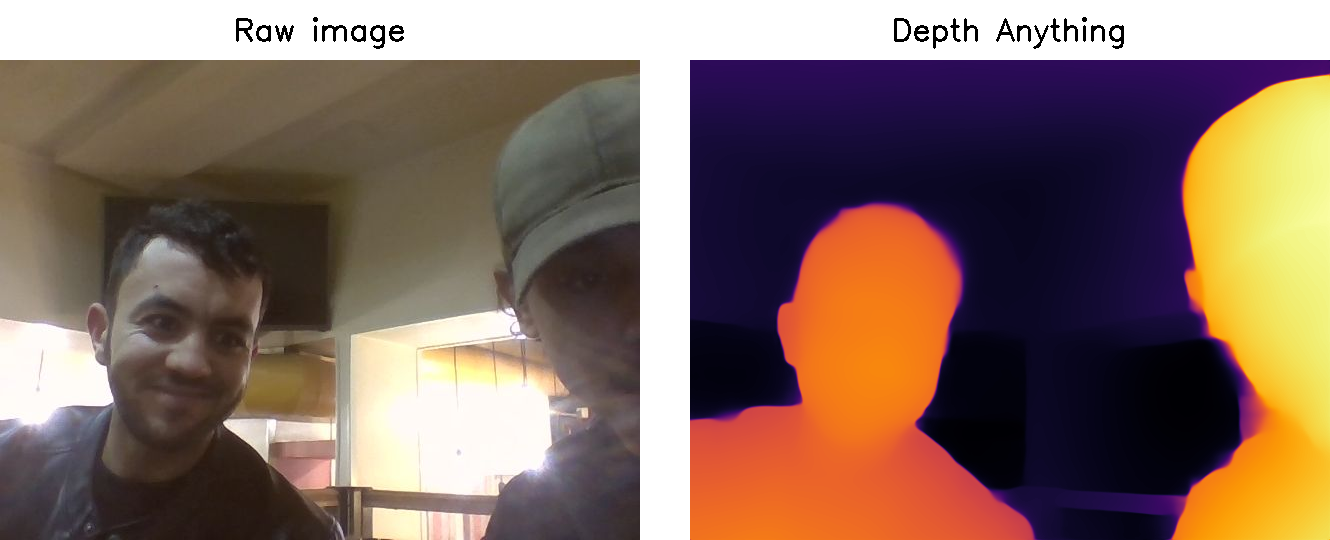

<IPython.core.display.Javascript object>

Stream stopped.


In [ ]:
from google.colab.patches import cv2_imshow  # Add this import
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
from tqdm import tqdm
from huggingface_hub import PyTorchModelHubMixin

# Define parameters for visualization
margin_width = 50
caption_height = 60
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 2

# Load the model
encoder = 'vits'  # You can change this to 'vitb' or 'vitl' if needed
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
depth_anything = DepthAnything.from_pretrained(f'LiheYoung/depth_anything_{encoder}14').to(DEVICE)
depth_anything.eval()

# Define the transformations
transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

# Main loop
try:
    while True:
        # Capture a frame from the webcam
        filename = take_photo()
        raw_image = cv2.imread(filename)

        # Resize the image
        raw_image = cv2.resize(raw_image, (640, 480))

        # Preprocess the image
        image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0
        h, w = image.shape[:2]
        image = transform({'image': image})['image']
        image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)

        # Predict depth
        with torch.no_grad():
            depth = depth_anything(image)

        # Postprocess the depth map
        depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
        depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        depth = depth.cpu().numpy().astype(np.uint8)
        depth_color = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

        # Combine the raw image and depth map
        split_region = np.ones((raw_image.shape[0], margin_width, 3), dtype=np.uint8) * 255
        combined_results = cv2.hconcat([raw_image, split_region, depth_color])

        # Add captions
        caption_space = np.ones((caption_height, combined_results.shape[1], 3), dtype=np.uint8) * 255
        captions = ['Raw image', 'Depth Anything']
        segment_width = w + margin_width
        for i, caption in enumerate(captions):
            text_size = cv2.getTextSize(caption, font, font_scale, font_thickness)[0]
            text_x = int((segment_width * i) + (w - text_size[0]) / 2)
            cv2.putText(caption_space, caption, (text_x, 40), font, font_scale, (0, 0, 0), font_thickness)

        final_result = cv2.vconcat([caption_space, combined_results])

        # Display the result
        cv2_imshow(final_result)  # Use cv2_imshow instead of cv2.imshow

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except KeyboardInterrupt:
    print("Stream stopped.")

# Release resources
cv2.destroyAllWindows()